# Before running

BEFORE RUNNING: 

1) Create zip files from "yes" and "no" folders and upload said folders to colab

2) Run the second cell below to unzip the zip files

3) Create a folder named "images" and place the two unzipped folders under it

4) Install the modules needed

# Imports

In [5]:
from data import get_radiomics_dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
import seaborn as sn
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import graphviz
from torch import nn
import torch.nn.functional as F
from pathlib import Path
import torch
from torch.utils.data import Subset, DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split
import torch.optim as optim
import os
import tensorflow as tf
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [6]:
randomstate = 0

# Load radionomic dataset and images

In [7]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = get_radiomics_dataset()

In [8]:
print(train_data.shape,val_data.shape,test_data.shape, train_labels.shape, val_labels.shape,test_labels.shape)

(222, 474) (28, 474) (28, 474) (222,) (28,) (28,)


Text(0, 0.5, 'Proportion in val set')

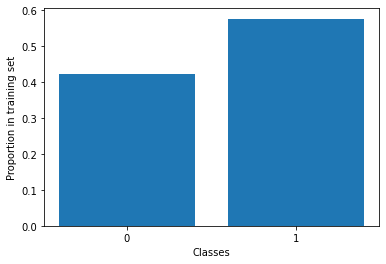

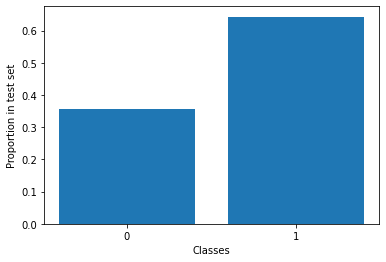

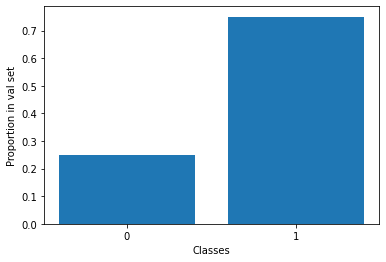

In [9]:
labels, counts = np.unique(train_labels, return_counts=True)
fig, ax = plt.subplots()
ax.set_xticks(labels)
ax.set_xlabel('Classes')
ax.bar(labels, counts/train_labels.shape[0], align='center')
ax.set_ylabel("Proportion in training set")

labels, counts = np.unique(val_labels, return_counts=True)
fig, ax = plt.subplots()
ax.set_xticks(labels)
ax.set_xlabel('Classes')
ax.bar(labels, counts/val_labels.shape[0], align='center')
ax.set_ylabel("Proportion in test set")

labels, counts = np.unique(test_labels, return_counts=True)
fig, ax = plt.subplots()
ax.set_xticks(labels)
ax.set_xlabel('Classes')
ax.bar(labels, counts/test_labels.shape[0], align='center')
ax.set_ylabel("Proportion in val set")

# Load images

In [ ]:
#Unzip the zip files
!unzip "/content/no.zip"
!unzip "/content/yes.zip"

In [ ]:
def get_img_dataset(transform=None):
    # Define data transform
    train_transform = []
    if transform is not None:
        train_transform+=transform
    train_transform += [
            transforms.Resize(128),             # resize shortest side to 128 pixels
            transforms.CenterCrop(128),         # crop longest side to 128 pixels at center
            transforms.ToTensor()               # convert PIL image to tensor
    ]
    train_transform = transforms.Compose(train_transform)
    test_transform=transforms.Compose([
            transforms.Resize(128),             # resize shortest side to 128 pixels
            transforms.CenterCrop(128),         # crop longest side to 128 pixels at center
            transforms.ToTensor()               # convert PIL image to tensor
    ])
    
    # Initialize train/test sets
    data_path = Path("images")
    train_dataset = ImageFolder(data_path, transform=train_transform)
    test_dataset = ImageFolder(data_path, transform=test_transform)
    classes = train_dataset.find_classes(data_path)[1]
    print(f"Loaded samples into dataset with label 'no'={classes['no']} and 'yes'={classes['yes']}")
    
    # Split dataset into train/test sets and stratify over labels to balance datasets with set seed 
    # DO NOT CHANGE THE SEED
    train_len = int(0.8*len(train_dataset))
    test_len = int((len(train_dataset)-train_len)/2)
    train_dataset = random_split(
        dataset=train_dataset, 
        lengths=[train_len, test_len, test_len],
        generator=torch.Generator().manual_seed(390397))[0]
    val_dataset, test_dataset = random_split(
        dataset=test_dataset, 
        lengths=[train_len, test_len, test_len],
        generator=torch.Generator().manual_seed(390397))[1:]
    
    return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset_mri, val_dataset_mri, test_dataset_mri = get_img_dataset()

In [ ]:
train_dataloader_mri = DataLoader(train_dataset_mri, batch_size=64, shuffle=True)
val_dataloader_mri = DataLoader(val_dataset_mri, batch_size=64,  shuffle=False)
test_dataloader_mri = DataLoader(test_dataset_mri, batch_size = 64, shuffle=False)

# Task 1 - Random Forest

## First approach without modification (100 trees)

In [21]:
model = RandomForestClassifier(random_state=randomstate)

model.fit(train_data,train_labels)
pred_test = model.predict(test_data)
pred_train = model.predict(train_data)
pred_val = model.predict(val_data)

f1 = f1_score(train_labels, pred_train, average="macro")
print("Train f1 score : %s "% f1)

acc = accuracy_score(train_labels, pred_train)
print("Train accuracy score : %s \n"% acc)

f1 = f1_score(val_labels, pred_val, average="macro")
print("Val f1 score : %s "% f1)

acc = accuracy_score(val_labels, pred_val)
print("Val accuracy score : %s \n"% acc)

f1 = f1_score(test_labels, pred_test, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(test_labels, pred_test)
print("Test accuracy score : %s \n"% acc)

Train f1 score : 1.0 
Train accuracy score : 1.0 

Val f1 score : 0.8008534850640113 
Val accuracy score : 0.8214285714285714 

Test f1 score : 0.672514619883041 
Test accuracy score : 0.7142857142857143 



In [22]:
sortedFeatures, sortedFeaturesNames = zip(*sorted(zip(model.feature_importances_, model.feature_names_in_),reverse=True))
sortedFeatures, sortedFeaturesNames = np.array(list(sortedFeatures)), np.array(list(sortedFeaturesNames))
print("There are", (sortedFeatures==0).sum(),"features with 0 importance, with a total of",len(sortedFeatures),"features")

There are 22 features with 0 importance, with a total of 474 features


<AxesSubplot:xlabel='feature_importance', ylabel='feature'>

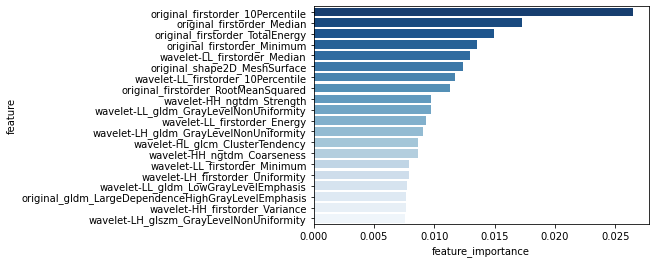

In [23]:
numberbestfeatures = 20
train_data_importantfeatures = train_data[sortedFeaturesNames[:numberbestfeatures]]
featureimportance = sortedFeatures[:numberbestfeatures]


d = {'feature': train_data_importantfeatures.columns, 'feature_importance': featureimportance}
df = pd.DataFrame(data=d)

sn.barplot(x="feature_importance", y="feature", data=df, palette="Blues_r")

## Use model with best number of trees

In [24]:
f1_scores = []
acc_scores = []
n_estimators = [i for i in range(1,10)] + [10*i for i in range(1,50)]
print("numbers of trees :",n_estimators)

for i in range(len(n_estimators)):
  model = RandomForestClassifier(n_estimators = n_estimators[i],random_state=randomstate)
  model.fit(train_data,train_labels)
  pred_val = model.predict(val_data)
  f1 = f1_score(val_labels, pred_val, average='macro')
  #print("i =",i,", n_estimators =",n_estimators[i], ", score =", f1)
  f1_scores.append(f1)  
  acc = accuracy_score(val_labels, pred_val)
  acc_scores.append(acc)

numbers of trees : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490]


You need n_estimators = 8
F1 val score with RandomForest : 0.8857142857142857


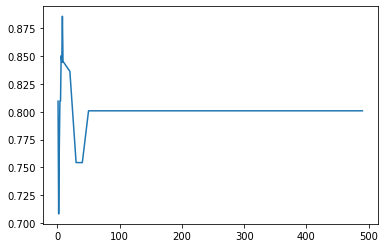

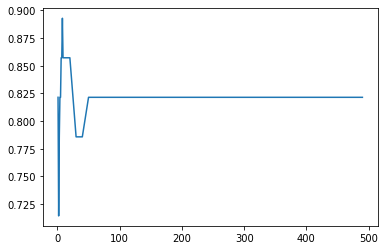

In [25]:
plt.figure()
plt.plot(n_estimators,f1_scores)
plt.figure()
plt.plot(n_estimators,acc_scores)

print("You need n_estimators =",n_estimators[np.argmax(f1_scores)])
print("F1 val score with RandomForest :", np.max(f1_scores))

In [26]:
model = RandomForestClassifier(n_estimators = n_estimators[np.argmax(f1_scores)],random_state=randomstate)
model.fit(train_data,train_labels)
pred_test = model.predict(test_data)
pred_train = model.predict(train_data)
pred_val = model.predict(val_data)

f1 = f1_score(train_labels, pred_train, average="macro")
print("Train f1 score : %s "% f1)

acc = accuracy_score(train_labels, pred_train)
print("Train accuracy score : %s \n"% acc)

f1 = f1_score(val_labels, pred_val, average="macro")
print("Val f1 score : %s "% f1)

acc = accuracy_score(val_labels, pred_val)
print("Val accuracy score : %s \n"% acc)

f1 = f1_score(test_labels, pred_test, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(test_labels, pred_test)
print("Test accuracy score : %s \n"% acc)

Train f1 score : 0.9815492021276595 
Train accuracy score : 0.9819819819819819 

Val f1 score : 0.8857142857142857 
Val accuracy score : 0.8928571428571429 

Test f1 score : 0.6111111111111112 
Test accuracy score : 0.6428571428571429 



There are 334 features with 0 importance, with a total of 474 features


<AxesSubplot:xlabel='feature_importance', ylabel='feature'>

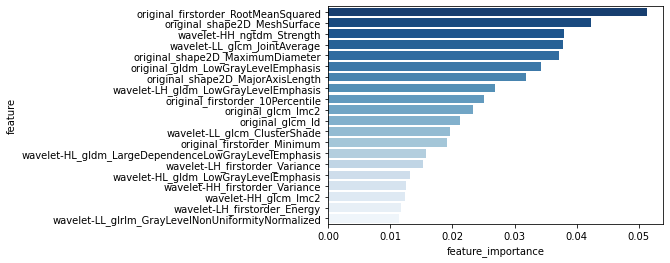

In [27]:
sortedFeatures, sortedFeaturesNames = zip(*sorted(zip(model.feature_importances_, model.feature_names_in_),reverse=True))
sortedFeatures, sortedFeaturesNames = np.array(list(sortedFeatures)), np.array(list(sortedFeaturesNames))
print("There are", (sortedFeatures==0).sum(),"features with 0 importance, with a total of",len(sortedFeatures),"features")

numberbestfeatures = 20
train_data_importantfeatures = train_data[sortedFeaturesNames[:numberbestfeatures]]
featureimportance = sortedFeatures[:numberbestfeatures]

d = {'feature': train_data_importantfeatures.columns, 'feature_importance': featureimportance}
df = pd.DataFrame(data=d)

sn.barplot(x="feature_importance", y="feature", data=df, palette="Blues_r")

# Task 2 - CNN and SHAP value

## CNN

In [ ]:
class BaselineClf_mri(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False), # 64x64
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False), # 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False), # 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False), # 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False), # 4x4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False), # 2x2
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(), 
            nn.Linear(512, 64, bias=False),
            nn.BatchNorm1d(64),

            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(dim=-1),
        )
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch 
        # Get predictions
        out = self(images)         
        # Get loss        
        loss = F.cross_entropy(out, labels) 
        return loss
    
    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        images, labels = batch 
        # Get predictions
        out = self(images)                    
        # Get loss
        loss = F.cross_entropy(out, labels)   
        # Get accuracy
        _, preds = torch.max(out, dim=1)
        acc = accuracy_score(labels.cpu(), preds.cpu())
        self.log("val_loss", loss)          
        return {'val_loss': loss, 'val_acc': acc}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
model = BaselineClf_mri()
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)#momentum=0.9)

In [ ]:
torch.set_grad_enabled(True)
num_epochs = 100

for epoch in range(num_epochs):  # loop over the dataset multiple times

    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader_mri, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        cur_loss = loss.item()
        if i % 10 == 0: #only print accuracy of first batch
            print(f'Training: [{epoch + 1}, {i + 1:5d}] loss: {cur_loss :.3f}')
    
    model.eval()
    for i, data in enumerate(train_dataloader_mri, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      outs = torch.argmax(model(inputs),1)

      train_acc = torch.sum(outs==labels)
      final_train_acc = train_acc/len(outs)
      print(f'Training accuracy: {final_train_acc :.3f}')

    for i, data in enumerate(val_dataloader_mri, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      outs = torch.argmax(model(inputs),1)

      val_acc = torch.sum(outs==labels)
      final_val_acc = val_acc/len(outs)
      print(f'Validation accuracy: {final_val_acc :.3f}')

print('Finished Training')

In [ ]:
model.eval()
for i, data in enumerate(val_dataloader_mri, 0):
  # get the inputs; data is a list of [inputs, labels]
  inputs, labels = data
  outs = torch.argmax(model(inputs),1)
  print(outs.shape)
  val_acc = torch.sum(outs ==labels)
  final_val_acc = val_acc/len(outs)
  print(outs)
  print(labels)
  print(final_val_acc)

## SHAP value estimation

In [ ]:
#Define background
background = torch.zeros((len(train_dataset_mri),3,128,128))
for i in range(len(train_dataset_mri)):
  background[i] = train_dataset_mri[i][0]

In [ ]:
plt.imshow(np.transpose(background[0],(1,2,0)), interpolation='nearest')

In [ ]:
#Pick 3 validation images that contain tumors because we can check that the importance of tumor locations is identified
batchy = next(iter(test_dataloader_mri))
test_images_pre,test_images_labels = batchy
test_images = test_images_pre[5:7]

In [ ]:
e = shap.DeepExplainer(model, background)

In [ ]:
shap_values = e.shap_values(test_images)

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

In [ ]:
shap.image_plot(shap_numpy, -test_numpy)

# Task 3 - Additional models

## Logistic Regression

### Scaling

In [28]:
scaler = StandardScaler()
scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)
print(train_data_scaled.shape)

test_data_scaled = scaler.transform(test_data)
val_data_scaled = scaler.transform(val_data)
print(test_data_scaled.shape,val_data_scaled.shape)

(222, 474)
(28, 474) (28, 474)


### Models with penalties

In [29]:
penalties = ["none","l1","l2"]

In [30]:
bestCl1 = 0
bestCl2 = 0
C_coef = [0.001, 0.05,0.1,0.5,1,2,3,4,5,6,7,8,9,10,50,100]
bestl1f1score = 0
bestl2f1score = 0

for penalty in penalties:
    f1_scores = []
    acc_scores = []

    if penalty!="none":

        for C in C_coef:
            model = LogisticRegression(C = C, max_iter = 1000, random_state=randomstate, penalty=penalty, solver="liblinear")
            model.fit(train_data_scaled,train_labels)
            pred_val = model.predict(val_data_scaled)
            f1 = f1_score(val_labels, pred_val, average='macro')
            f1_scores.append(f1)
            acc = accuracy_score(val_labels, pred_val)
            acc_scores.append(acc)

        if penalty == "l1":
            bestCl1 = C_coef[np.argmax(f1_scores)]
            bestl1f1score = np.max(f1_scores)
        if penalty == "l2":
            bestCl2 = C_coef[np.argmax(f1_scores)]
            bestl2f1score = np.max(f1_scores)

        print("penalty:",penalty, ", max f1 val score:",np.max(f1_scores), ", best C coefficient:",C_coef[np.argmax(f1_scores)])

    else:
        model = LogisticRegression(max_iter = 1000, random_state=randomstate, penalty=penalty)
        model.fit(train_data_scaled,train_labels)
        pred_val = model.predict(val_data_scaled)
        f1 = f1_score(val_labels, pred_val, average='macro')
        acc = accuracy_score(val_labels, pred_val)

        print("penalty:",penalty, ", f1 val score:",f1)


penalty: none , f1 val score: 0.7754010695187166
penalty: l1 , max f1 val score: 0.8362573099415205 , best C coefficient: 1
penalty: l2 , max f1 val score: 0.8095238095238095 , best C coefficient: 2


Penalty: l1 , you need C_coef = 1
F1 val score with Logistic regression : 0.8362573099415205
Penalty: l2 , you need C_coef = 2
F1 val score with Logistic regression : 0.8095238095238095


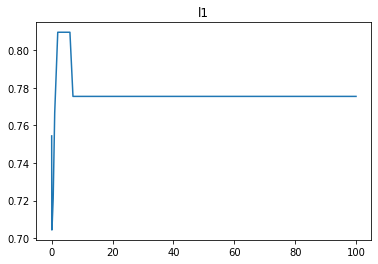

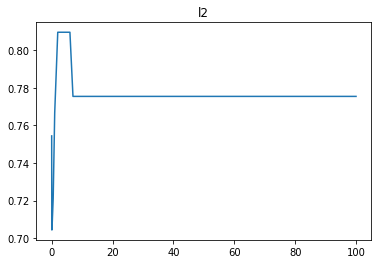

In [31]:
for penalty in penalties:
    if penalty!="none":
        plt.figure()
        plt.plot(C_coef,f1_scores)
        plt.title(penalty)
        # plt.figure()
        # plt.plot(C_coef,acc_scores)
        
        if penalty == "l1":
            print("Penalty:",penalty,", you need C_coef =",bestCl1)
            print("F1 val score with Logistic regression :", bestl1f1score)
        if penalty == "l2":
            print("Penalty:",penalty,", you need C_coef =",bestCl2)
            print("F1 val score with Logistic regression :", bestl2f1score)
        

In [32]:
models = []
for penalty in penalties:
    print("--------- PENALTY :",penalty,"------")
    if penalty=="l1":
        C = bestCl1
        model = LogisticRegression(C = C, max_iter = 1000, random_state=randomstate, penalty=penalty, solver="liblinear")
    elif penalty=="l2":
        C = bestCl2
        model = LogisticRegression(C = C, max_iter = 1000, random_state=randomstate, penalty=penalty, solver="liblinear")
    else:
        model = LogisticRegression(max_iter = 1000, random_state=randomstate,penalty=penalty)

    model.fit(train_data_scaled,train_labels)
    models.append(model)

    pred_test = model.predict(test_data_scaled)
    pred_train = model.predict(train_data_scaled)
    pred_val = model.predict(val_data_scaled)

    f1 = f1_score(train_labels, pred_train, average="macro")
    print("Train f1 score : %s "% f1)

    acc = accuracy_score(train_labels, pred_train)
    print("Train accuracy score : %s \n"% acc)

    f1 = f1_score(val_labels, pred_val, average="macro")
    print("Val f1 score : %s "% f1)

    acc = accuracy_score(val_labels, pred_val)
    print("Val accuracy score : %s \n"% acc)

    f1 = f1_score(test_labels, pred_test, average="macro")
    print("Test f1 score : %s "% f1)

    acc = accuracy_score(test_labels, pred_test)
    print("Test accuracy score : %s \n"% acc)

--------- PENALTY : none ------
Train f1 score : 1.0 
Train accuracy score : 1.0 

Val f1 score : 0.7754010695187166 
Val accuracy score : 0.7857142857142857 

Test f1 score : 0.7543859649122806 
Test accuracy score : 0.7857142857142857 

--------- PENALTY : l1 ------
Train f1 score : 0.9443143812709031 
Train accuracy score : 0.9459459459459459 

Val f1 score : 0.8362573099415205 
Val accuracy score : 0.8571428571428571 

Test f1 score : 0.7375 
Test accuracy score : 0.7857142857142857 

--------- PENALTY : l2 ------
Train f1 score : 0.9815996684624948 
Train accuracy score : 0.9819819819819819 

Val f1 score : 0.8095238095238095 
Val accuracy score : 0.8214285714285714 

Test f1 score : 0.7043740573152337 
Test accuracy score : 0.75 



penalty: none
There are 3 features with 0 importance, with a total of 474 features
penalty: l1
There are 402 features with 0 importance, with a total of 474 features
penalty: l2
There are 3 features with 0 importance, with a total of 474 features


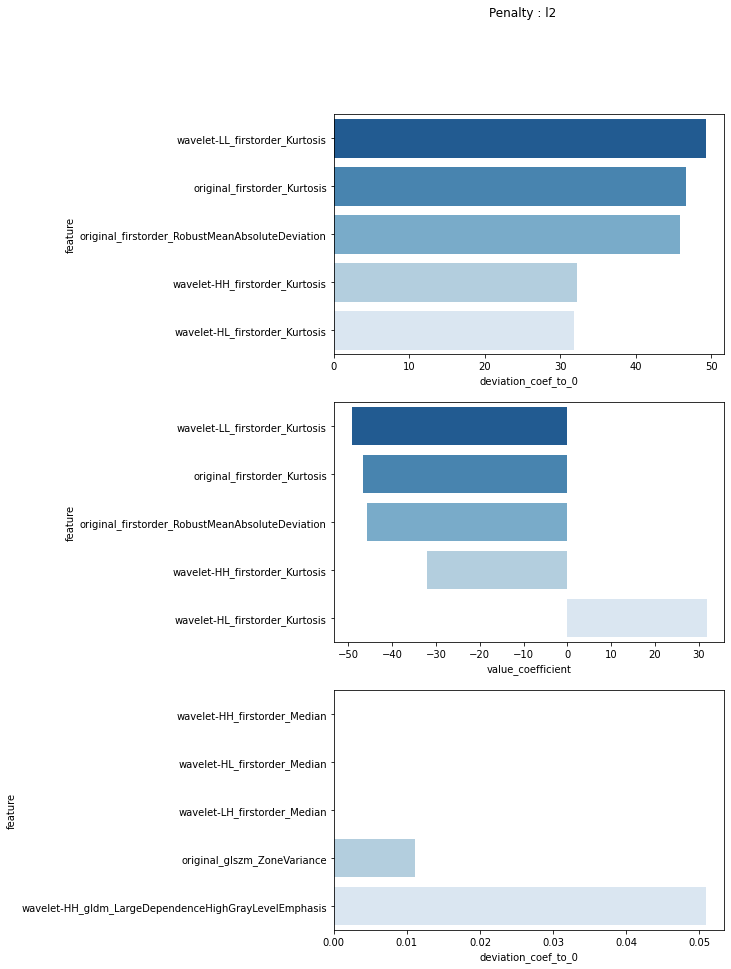

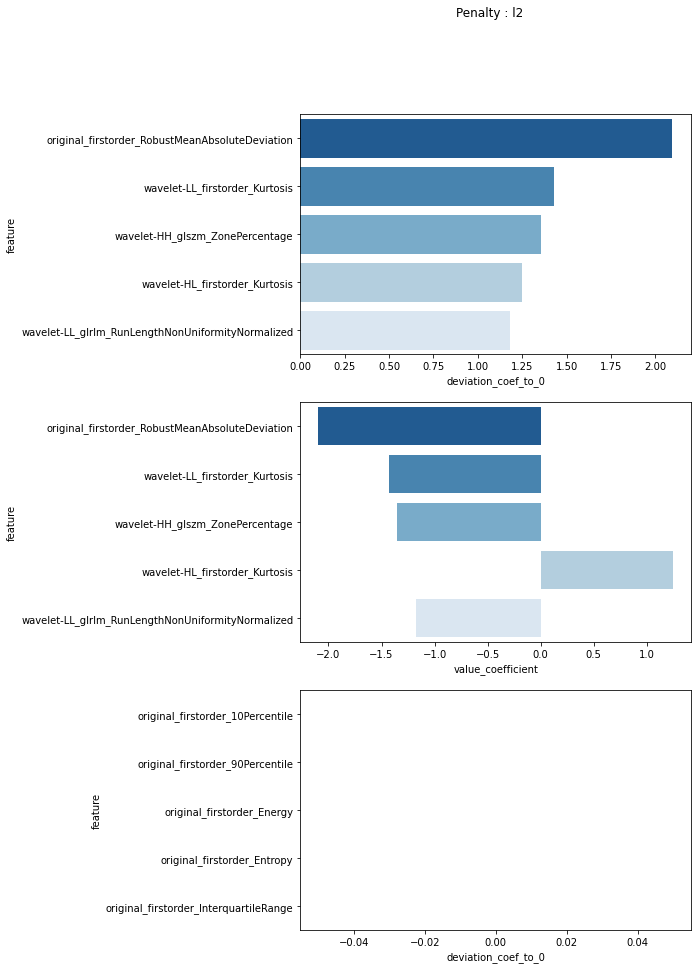

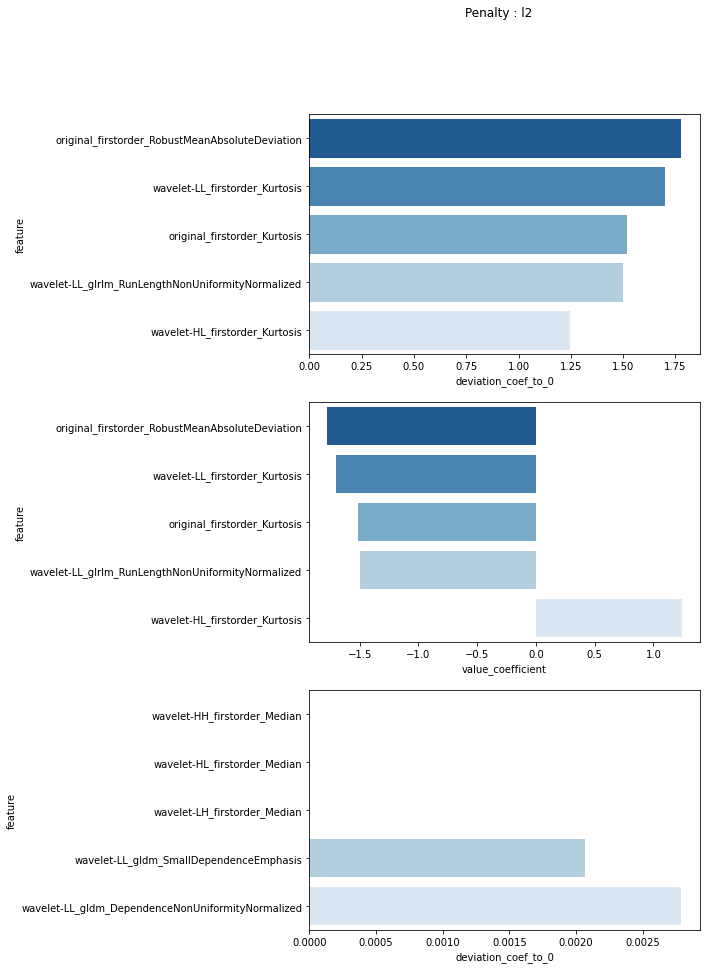

In [41]:
for i in range(3):
    print("penalty:", penalties[i])
    model = models[i]
    coefs = model.coef_[0]
    importance = np.abs(coefs)
        
    sortedFeatures, sortedFeaturesNames, sortedCoefs = zip(*sorted(zip(importance, np.array(train_data.keys()), coefs),reverse=True))
    sortedFeatures, sortedFeaturesNames, sortedCoefs = np.array(list(sortedFeatures)), np.array(list(sortedFeaturesNames)), np.array(list(sortedCoefs))

    print("There are", (sortedFeatures==0).sum(),"features with 0 importance, with a total of",len(sortedFeatures),"features")

    numberbestfeatures = 5
    train_data_importantfeatures = train_data[sortedFeaturesNames[:numberbestfeatures]]
    coefsbestfeatures = sortedCoefs[:numberbestfeatures]


    d = {'feature': train_data_importantfeatures.columns, 'coefficient': coefsbestfeatures, 'odds': np.exp(coefsbestfeatures), 'deviation_coef_to_0': abs(coefsbestfeatures)}
    df = pd.DataFrame(data=d)

    plt.figure(figsize = (7,15))
    plt.suptitle("Penalty : " + penalty)
    plt.subplot(3,1,1)
    sn.barplot(x="deviation_coef_to_0", y="feature", data=df, palette="Blues_r")

    d = {'feature': train_data_importantfeatures.columns, 'coefficient': coefsbestfeatures, 'odds': np.exp(coefsbestfeatures), 'value_coefficient': coefsbestfeatures}
    df = pd.DataFrame(data=d)

    plt.subplot(3,1,2)
    sn.barplot(x="value_coefficient", y="feature", data=df, palette="Blues_r")

    numberworstfeatures = 5
    train_data_importantfeatures = train_data[sortedFeaturesNames[-numberworstfeatures:]]
    coefsbestfeatures = sortedCoefs[-numberworstfeatures:]

    d = {'feature': train_data_importantfeatures.columns, 'coefficient': coefsbestfeatures, 'odds': np.exp(coefsbestfeatures), 'deviation_coef_to_0': abs(coefsbestfeatures)}
    df = pd.DataFrame(data=d)
    df = df[::-1].reset_index(drop = True)

    plt.subplot(3,1,3)
    sn.barplot(x="deviation_coef_to_0", y="feature", data=df, palette="Blues_r")


## Decision tree

In [42]:
model = DecisionTreeClassifier(random_state=randomstate)
model.fit(train_data,train_labels)

pred_test = model.predict(test_data)
pred_train = model.predict(train_data)
pred_val = model.predict(val_data)

f1 = f1_score(train_labels, pred_train, average="macro")
print("Train f1 score : %s "% f1)

acc = accuracy_score(train_labels, pred_train)
print("Train accuracy score : %s \n"% acc)

f1 = f1_score(val_labels, pred_val, average="macro")
print("Val f1 score : %s "% f1)

acc = accuracy_score(val_labels, pred_val)
print("Val accuracy score : %s \n"% acc)

f1 = f1_score(test_labels, pred_test, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(test_labels, pred_test)
print("Test accuracy score : %s \n"% acc)

Train f1 score : 1.0 
Train accuracy score : 1.0 

Val f1 score : 0.8502673796791445 
Val accuracy score : 0.8571428571428571 

Test f1 score : 0.6571428571428573 
Test accuracy score : 0.6785714285714286 



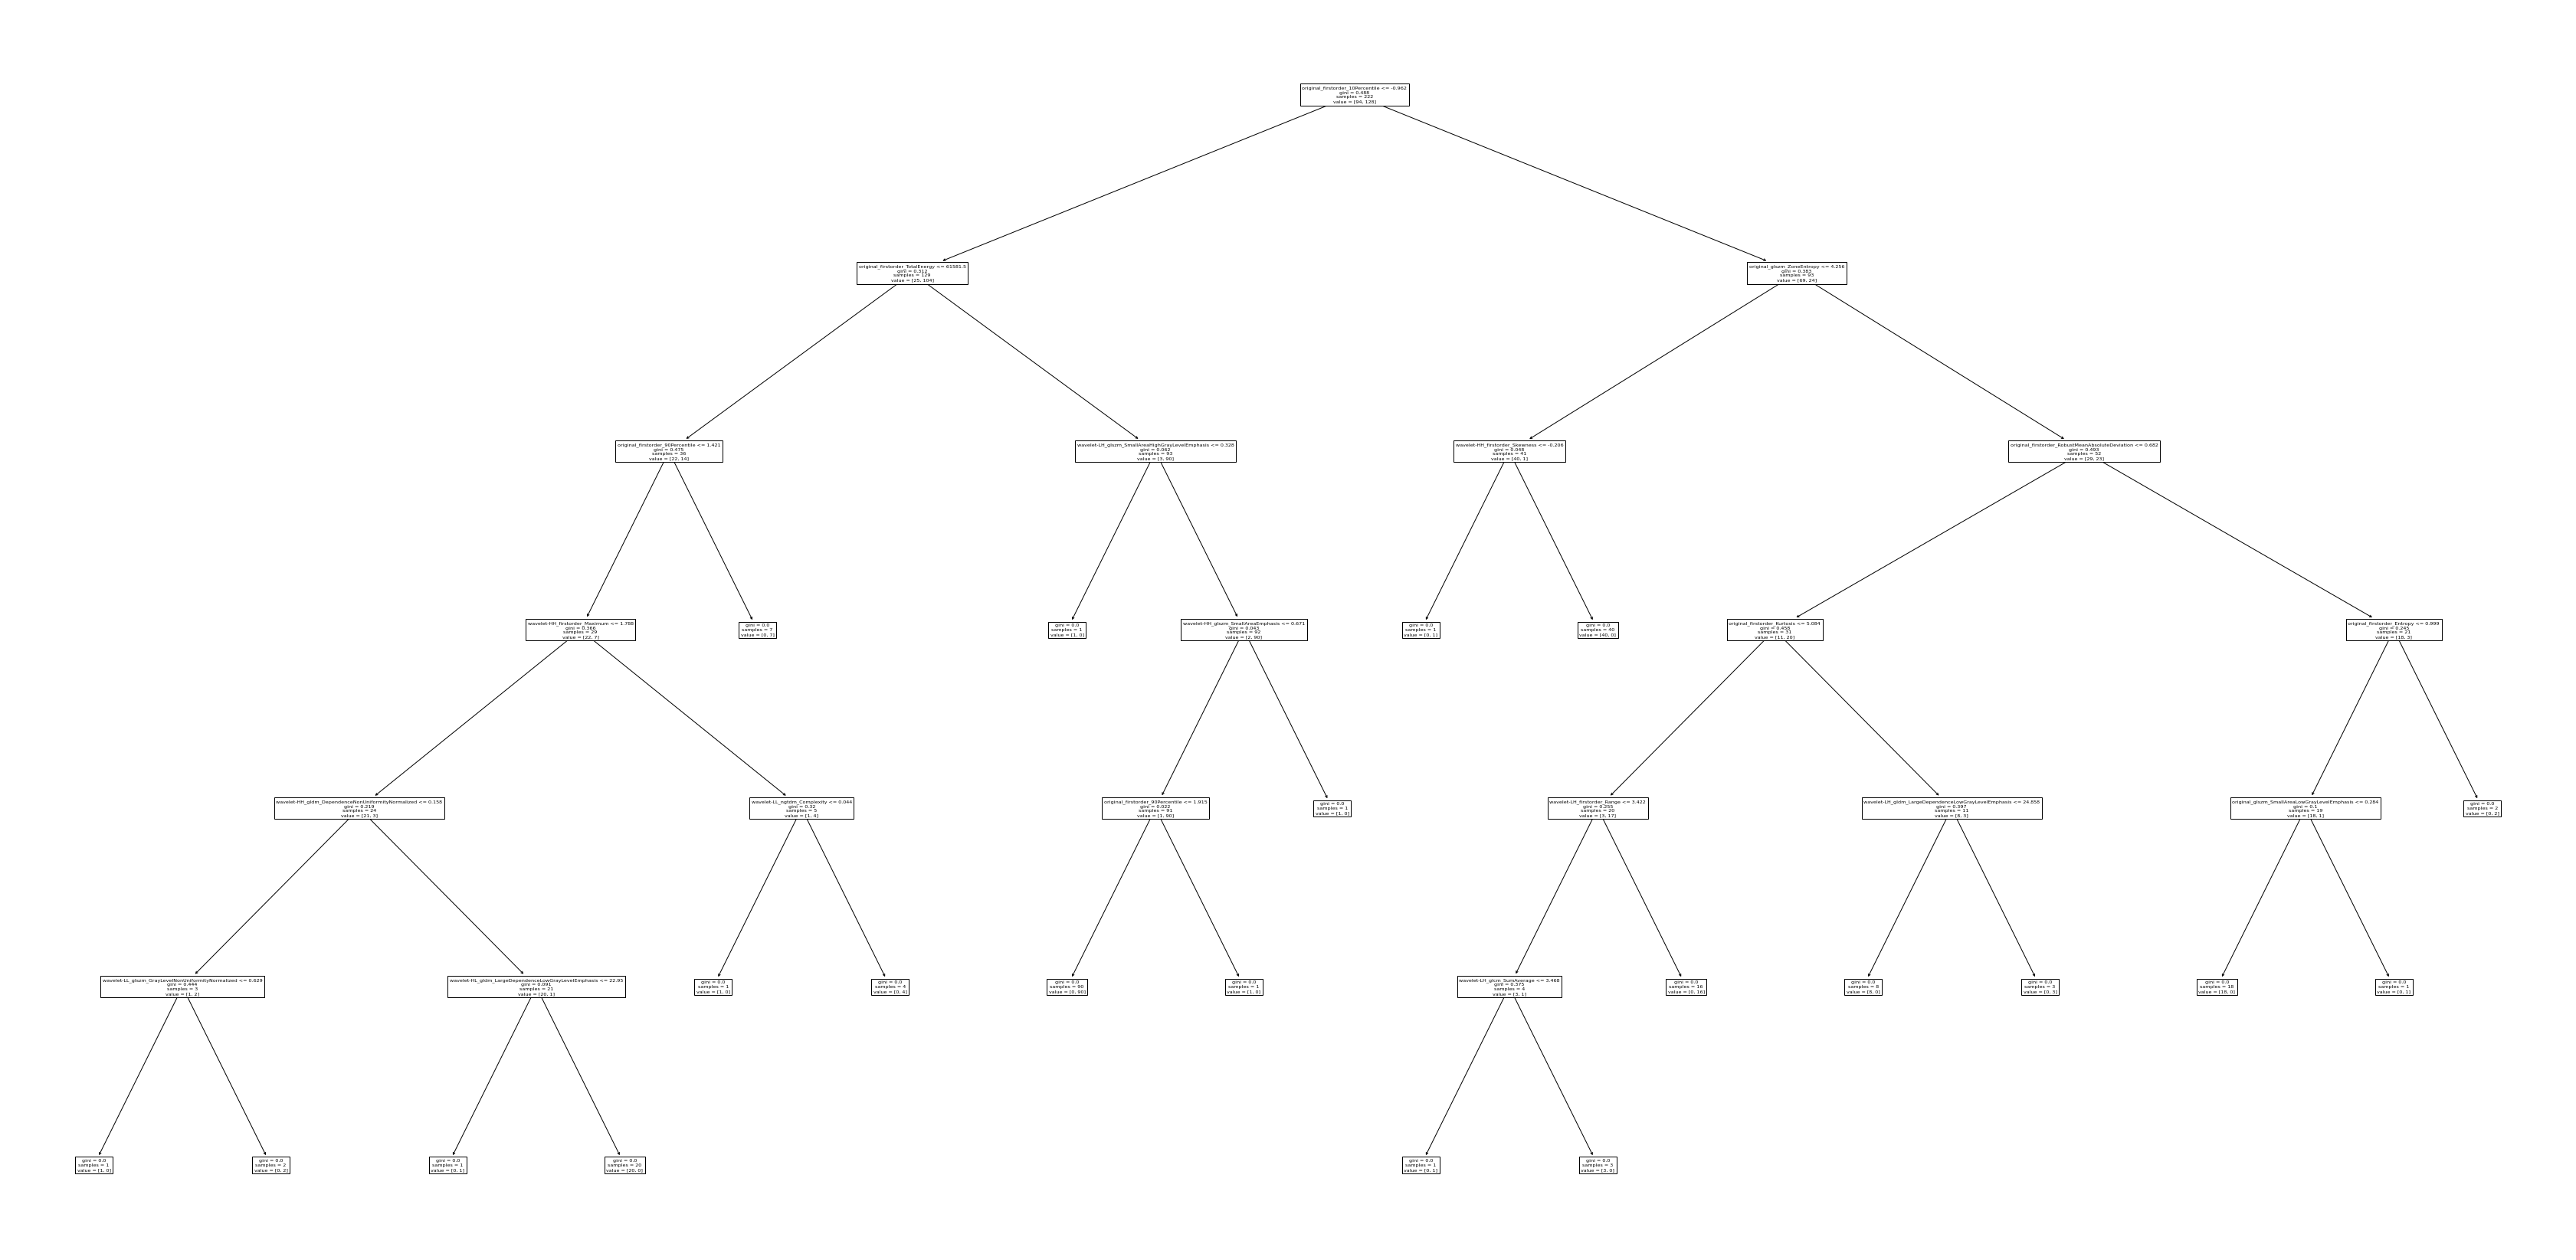

In [43]:
plt.figure(figsize=(60,30))
plot_tree(model,feature_names=model.feature_names_in_)
plt.show()

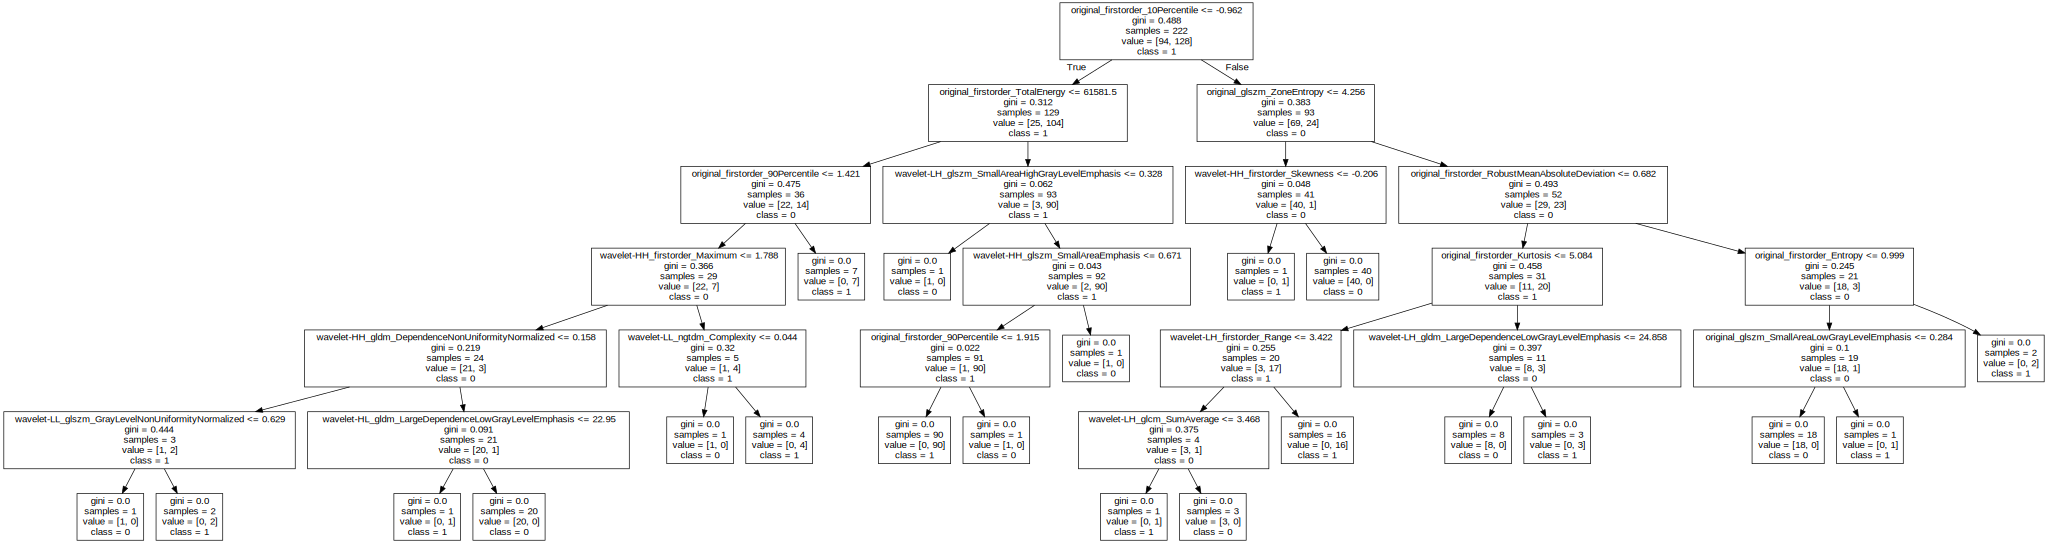

In [44]:
dot_data = export_graphviz(model, out_file=None, class_names=["0","1"],
                                feature_names=model.feature_names_in_)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

There are 455 features with 0 importance, with a total of 474 features


<AxesSubplot:xlabel='feature_importance', ylabel='feature'>

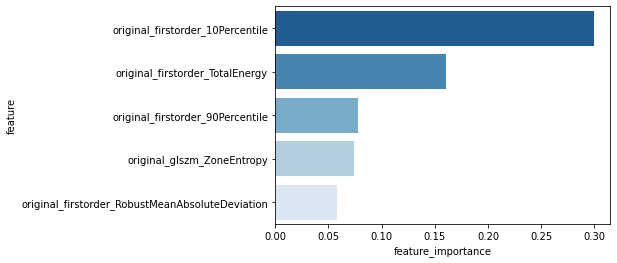

In [45]:
sortedFeatures, sortedFeaturesNames = zip(*sorted(zip(model.feature_importances_, model.feature_names_in_),reverse=True))
sortedFeatures, sortedFeaturesNames = np.array(list(sortedFeatures)), np.array(list(sortedFeaturesNames))

print("There are", (sortedFeatures==0).sum(),"features with 0 importance, with a total of",len(sortedFeatures),"features")

numberbestfeatures = 5
train_data_importantfeatures = train_data[sortedFeaturesNames[:numberbestfeatures]]
featureimportance = sortedFeatures[:numberbestfeatures]

d = {'feature': train_data_importantfeatures.columns, 'feature_importance': featureimportance}
df = pd.DataFrame(data=d)

sn.barplot(x="feature_importance", y="feature", data=df, palette="Blues_r")

## PCA

### Find best percentage of the variance to keep

In [46]:
f1_scores = []
acc_scores = []
number_features_list = []

pca = PCA() 
pca.fit(train_data_scaled)
X_train_PCA = pca.transform(train_data_scaled)
print("Nombre de features :", X_train_PCA.shape[1], ", nombre samples :", X_train_PCA.shape[0])

var_explained = pca.explained_variance_ratio_*100 
print("Variance pca des nouvelles features :\n",var_explained)

variances = np.arange(90,100.1,0.1)
print(variances)

for variancetokeep in variances:
    number_features = np.argmax(np.cumsum(var_explained)>=variancetokeep)+1 

    X_train_PCA_numberfeatures = X_train_PCA[:,:number_features]
    X_val_PCA = pca.transform(val_data_scaled)
    X_val_PCA_number_features = X_val_PCA[:,:number_features]

    model = RandomForestClassifier(random_state=randomstate)
    model.fit(X_train_PCA_numberfeatures,train_labels)
    pred_val = model.predict(X_val_PCA_number_features)
    f1 = f1_score(val_labels, pred_val, average='macro')
    f1_scores.append(f1)  
    acc = accuracy_score(val_labels, pred_val)
    acc_scores.append(acc)
    
    print("Number features to keep",variancetokeep, "percent of the variance :",number_features, "score =", f1)

    number_features_list.append(number_features)

Nombre de features : 222 , nombre samples : 222
Variance pca des nouvelles features :
 [3.56261974e+01 1.83484524e+01 8.85908603e+00 6.38847381e+00
 3.98012590e+00 3.43824837e+00 2.57342782e+00 2.30746960e+00
 1.88202868e+00 1.55008019e+00 1.42348552e+00 1.06410733e+00
 1.01812274e+00 9.07325263e-01 8.59592763e-01 6.37141670e-01
 6.11289064e-01 5.32523151e-01 4.58665341e-01 4.51240414e-01
 4.41483111e-01 4.09158507e-01 3.76429012e-01 3.48532259e-01
 3.27503911e-01 2.89063339e-01 2.76073215e-01 2.56516279e-01
 2.31179372e-01 2.23199499e-01 2.17539166e-01 2.13147822e-01
 1.98027730e-01 1.89066960e-01 1.72085116e-01 1.67171283e-01
 1.55785434e-01 1.46582950e-01 1.43796687e-01 1.32265129e-01
 1.27531493e-01 1.18284025e-01 1.15059161e-01 1.09875600e-01
 1.05472517e-01 9.73871100e-02 9.35810126e-02 8.22890684e-02
 7.47789920e-02 7.09580127e-02 6.65986517e-02 5.85600236e-02
 5.31565536e-02 5.24262769e-02 4.78138694e-02 4.66699144e-02
 4.44359777e-02 4.32989263e-02 3.98914388e-02 3.54124847e-0

You need number_features_list = 35
It expresses 96.9999999999996 percent of the variance
F1 val score with RandomForest : 0.7888386123680241


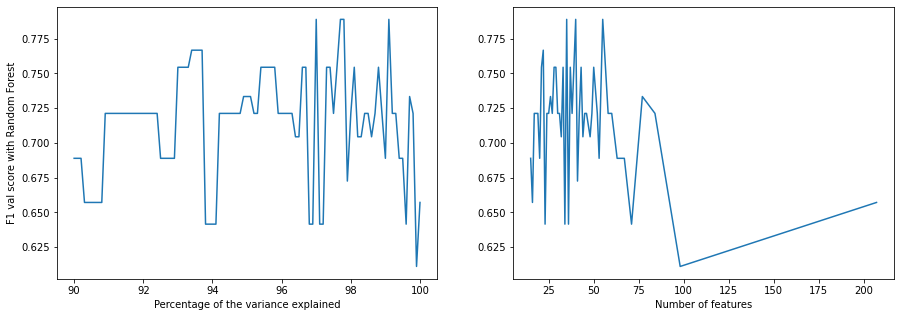

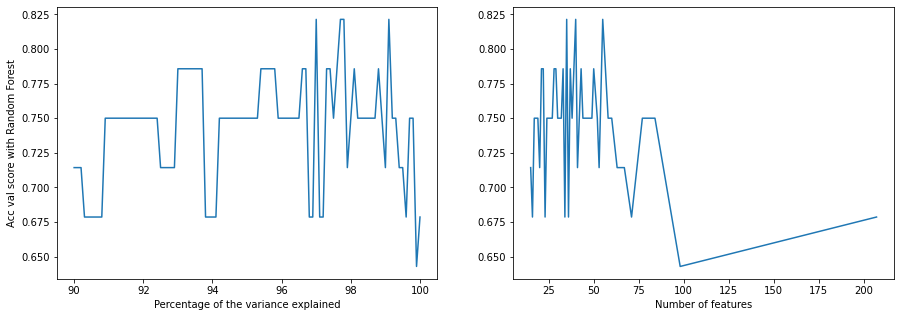

In [47]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(variances,f1_scores)
plt.xlabel("Percentage of the variance explained")
plt.ylabel("F1 val score with Random Forest")
plt.subplot(1,2,2)
plt.plot(number_features_list,f1_scores)
plt.xlabel("Number of features")

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(variances,acc_scores)
plt.xlabel("Percentage of the variance explained")
plt.ylabel("Acc val score with Random Forest")
plt.subplot(1,2,2)
plt.plot(number_features_list,acc_scores)
plt.xlabel("Number of features")

print("You need number_features_list =",number_features_list[np.argmax(f1_scores)])
print("It expresses",variances[np.argmax(f1_scores)], "percent of the variance")
print("F1 val score with RandomForest :", np.max(f1_scores))

In [48]:
variancetokeep = variances[np.argmax(f1_scores)]
number_features = np.argmax(np.cumsum(var_explained)>=variancetokeep)+1 
print("Best model: Number features to keep",variancetokeep, "percent of the variance :",number_features)

X_train_PCA_numberfeatures = X_train_PCA[:,:number_features]
X_val_PCA = pca.transform(val_data_scaled)
X_val_PCA_number_features = X_val_PCA[:,:number_features]
X_test_PCA = pca.transform(test_data_scaled)
X_test_PCA_number_features = X_test_PCA[:,:number_features]

model = RandomForestClassifier(random_state=randomstate)

model.fit(X_train_PCA_numberfeatures,train_labels)
pred_test = model.predict(X_test_PCA_number_features)
pred_train = model.predict(X_train_PCA_numberfeatures)
pred_val = model.predict(X_val_PCA_number_features)

f1 = f1_score(train_labels, pred_train, average="macro")
print("Train f1 score : %s "% f1)

acc = accuracy_score(train_labels, pred_train)
print("Train accuracy score : %s \n"% acc)

f1 = f1_score(val_labels, pred_val, average="macro")
print("Val f1 score : %s "% f1)

acc = accuracy_score(val_labels, pred_val)
print("Val accuracy score : %s \n"% acc)

f1 = f1_score(test_labels, pred_test, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(test_labels, pred_test)
print("Test accuracy score : %s \n"% acc)

Best model: Number features to keep 96.9999999999996 percent of the variance : 35
Train f1 score : 1.0 
Train accuracy score : 1.0 

Val f1 score : 0.7888386123680241 
Val accuracy score : 0.8214285714285714 

Test f1 score : 0.7142857142857142 
Test accuracy score : 0.7857142857142857 



Text(0, 0.5, 'Percentage of the total variance explained')

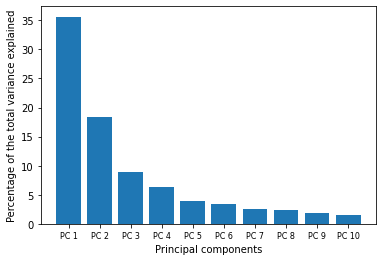

In [49]:
numbercomponent = 10
labels = ["PC " + str(i) for i in range(1,numbercomponent + 1)]
counts = var_explained[:numbercomponent]

fig, ax = plt.subplots()
ax.set_xticks([i for i in range(len(labels))])
ax.set_xticklabels(labels,fontsize='8')
ax.set_xlabel('Principal components')
ax.bar(labels, counts, align='center')
ax.set_ylabel("Percentage of the total variance explained")

You need 15 principal components to express 90 percent of the variance


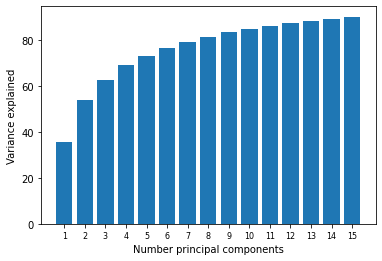

In [50]:
numbercomponent90Variance = np.argmax(np.cumsum(var_explained)>=90)+1
labels = [str(i) for i in range(1,numbercomponent90Variance + 1)]
counts = np.cumsum(var_explained[:numbercomponent90Variance])

fig, ax = plt.subplots()
ax.set_xticks([i for i in range(len(labels))])
ax.set_xticklabels(labels,fontsize='8')
ax.set_xlabel('Number principal components')
ax.bar(labels, counts, align='center')
ax.set_ylabel("Variance explained")

print("You need",numbercomponent90Variance,"principal components to express 90 percent of the variance")

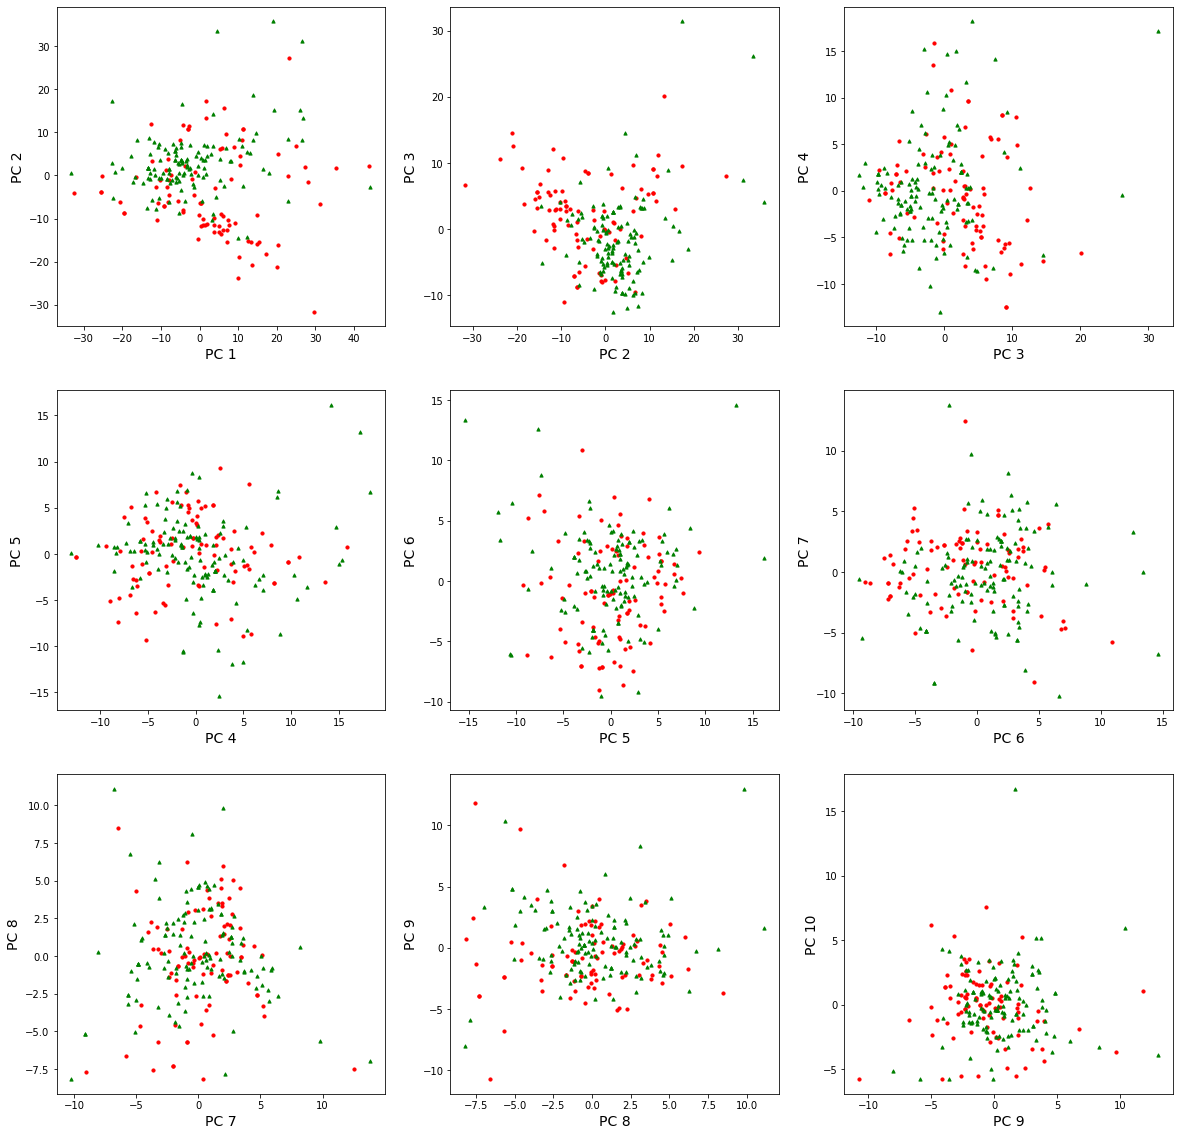

In [51]:
cdict = {0:'red',1:'green'}
labl = {0:'0',1:'1'}
marker = {0:'o',1:'^'}

plt.figure(figsize=(20,20))

for i in range(numbercomponent-1):
   plt.subplot(3,3,i+1)

   for l in np.unique(train_labels):
    ix=np.where(train_labels==l)
    plt.scatter(x=X_train_PCA_numberfeatures[ix,i], 
       y=X_train_PCA_numberfeatures[ix,i+1], c=cdict[l], s=10,
              label=labl[l], marker=marker[l])

   plt.xlabel("PC "+str(i+1), fontsize=14)
   plt.ylabel("PC "+str(i+2), fontsize=14)

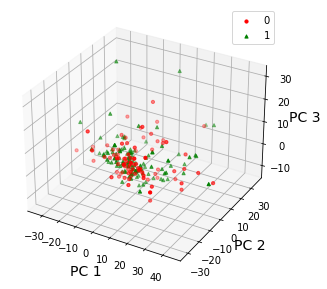

In [52]:
cdict = {0:'red',1:'green'}
labl = {0:'0',1:'1'}
marker = {0:'o',1:'^'}

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(train_labels):
 ix=np.where(train_labels==l)
 ax.scatter(xs=X_train_PCA_numberfeatures[ix,0], 
    ys=X_train_PCA_numberfeatures[ix,1], 
    zs=X_train_PCA_numberfeatures[ix,2], c=cdict[l], s=10,
           label=labl[l], marker=marker[l])

ax.set_xlabel("PC 1", fontsize=14)
ax.set_ylabel("PC 2", fontsize=14)
ax.set_zlabel("PC 3", fontsize=14)

ax.legend()
plt.show()

### Find best percentage of variance and best number of trees for Random Forest

In [53]:
f1_scores_lists = []
acc_scores_lists = []
number_features_lists = []
n_estimators = [i for i in range(1,50)]
variances = np.arange(90,100.1,0.1)

pca = PCA() 
pca.fit(train_data_scaled)
X_train_PCA = pca.transform(train_data_scaled)
var_explained = pca.explained_variance_ratio_*100 

for variancetokeep in variances:
  f1_scores = []
  acc_scores = []

  number_features = np.argmax(np.cumsum(var_explained)>=variancetokeep)+1 
  number_features_lists.append(number_features)

  X_train_PCA_numberfeatures = X_train_PCA[:,:number_features]
  X_val_PCA = pca.transform(val_data_scaled)
  X_val_PCA_number_features = X_val_PCA[:,:number_features]

  for i in range(len(n_estimators)):

    model = RandomForestClassifier(n_estimators = n_estimators[i],random_state=randomstate)
    model.fit(X_train_PCA_numberfeatures,train_labels)
    pred_val = model.predict(X_val_PCA_number_features)
    f1 = f1_score(val_labels, pred_val, average='macro')
    f1_scores.append(f1)  
    acc = accuracy_score(val_labels, pred_val)
    acc_scores.append(acc)

    print("Number features to keep",variancetokeep, "percent of the variance :",number_features, "n_estimators =",n_estimators[i], "f1 val score =", f1)

  f1_scores_lists.append(f1_scores)
  acc_scores_lists.append(acc_scores)

Number features to keep 90.0 percent of the variance : 15 n_estimators = 1 f1 val score = 0.6679841897233201
Number features to keep 90.0 percent of the variance : 15 n_estimators = 2 f1 val score = 0.5692307692307692
Number features to keep 90.0 percent of the variance : 15 n_estimators = 3 f1 val score = 0.657142857142857
Number features to keep 90.0 percent of the variance : 15 n_estimators = 4 f1 val score = 0.657142857142857
Number features to keep 90.0 percent of the variance : 15 n_estimators = 5 f1 val score = 0.7211948790896159
Number features to keep 90.0 percent of the variance : 15 n_estimators = 6 f1 val score = 0.6888888888888889
Number features to keep 90.0 percent of the variance : 15 n_estimators = 7 f1 val score = 0.6888888888888889
Number features to keep 90.0 percent of the variance : 15 n_estimators = 8 f1 val score = 0.6888888888888889
Number features to keep 90.0 percent of the variance : 15 n_estimators = 9 f1 val score = 0.6415362731152204
Number features to ke

In [54]:
variancetokeepindex = np.argmax(f1_scores_lists)//len(n_estimators)
nestimatorindex = np.argmax(f1_scores_lists)%len(n_estimators)
print("best model: variance expression=",variances[variancetokeepindex],",number features:",number_features_lists[variancetokeepindex], "n_estimators:",n_estimators[nestimatorindex])

best model: variance expression= 99.89999999999944 ,number features: 98 n_estimators: 9


In [55]:
print("You need number_features =",number_features_list[variancetokeepindex])
print("It expresses",variances[variancetokeepindex], "percent of the variance")
print("F1 val score with RandomForest :", np.max(f1_scores_lists))

You need number_features = 98
It expresses 99.89999999999944 percent of the variance
F1 val score with RandomForest : 0.8893280632411067


In [56]:
variancetokeep = variances[variancetokeepindex]
n_estimators = n_estimators[nestimatorindex]
number_features = np.argmax(np.cumsum(var_explained)>=variancetokeep)+1 
print("Number features to keep",variancetokeep, "percent of the variance :",number_features)

X_train_PCA_numberfeatures = X_train_PCA[:,:number_features]
X_val_PCA = pca.transform(val_data_scaled)
X_val_PCA_number_features = X_val_PCA[:,:number_features]
X_test_PCA = pca.transform(test_data_scaled)
X_test_PCA_number_features = X_test_PCA[:,:number_features]

model = RandomForestClassifier(n_estimators = n_estimators, random_state=randomstate)

model.fit(X_train_PCA_numberfeatures,train_labels)
pred_test = model.predict(X_test_PCA_number_features)
pred_train = model.predict(X_train_PCA_numberfeatures)
pred_val = model.predict(X_val_PCA_number_features)

f1 = f1_score(train_labels, pred_train, average="macro")
print("Train f1 score : %s "% f1)

acc = accuracy_score(train_labels, pred_train)
print("Train accuracy score : %s \n"% acc)

f1 = f1_score(val_labels, pred_val, average="macro")
print("Val f1 score : %s "% f1)

acc = accuracy_score(val_labels, pred_val)
print("Val accuracy score : %s \n"% acc)

f1 = f1_score(test_labels, pred_test, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(test_labels, pred_test)
print("Test accuracy score : %s \n"% acc)

Number features to keep 99.89999999999944 percent of the variance : 98
Train f1 score : 0.9907476869217304 
Train accuracy score : 0.990990990990991 

Val f1 score : 0.8893280632411067 
Val accuracy score : 0.8928571428571429 

Test f1 score : 0.6493738819320215 
Test accuracy score : 0.75 



## Post-hoc interpretation method

In [ ]:
def batch_predict(images):
  global model
  with torch.no_grad():
    model_temp = model
    model_temp.eval()
    batch = torch.stack(tuple(torch.tensor(np.transpose(i,(2,1,0))) for i in images), dim=0)

    batch = batch.float()
    model_temp = model_temp.float()
    logits = model_temp(batch)
    probs = F.softmax(logits, dim=1)
    return np.array(probs.detach().cpu().numpy(),dtype = np.double)

In [ ]:
#lime for 6th test image
explainer_lime_5 = lime_image.LimeImageExplainer()
explanation_lime_5 = explainer_lime_5.explain_instance(np.transpose(np.array(test_images_pre[5],dtype = np.double),(1,2,0)), 
                                         batch_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

In [ ]:
#lime for 7th test image
explainer_lime_6 = lime_image.LimeImageExplainer()
explanation_lime_6 = explainer_lime_6.explain_instance(np.transpose(np.array(test_images_pre[6],dtype = np.double),(1,2,0)), 
                                         batch_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

In [ ]:
#The pixels that favour tumor presence, without color of importance, for 6th test image
temp, mask = explanation_lime_5.get_image_and_mask(explanation_lime_5.top_labels[1], positive_only=True, num_features=10, hide_rest=False)
img_boundry1 = mark_boundaries(temp, mask)
plt.imshow(img_boundry1)

In [ ]:
# With color for 6th test image: green are the part of the image contributing to a diagnosis being tumor. Again, due to the small sample size, we can see that in fact 
# there is a lot of noise and that has led to a number of features contributing that are in fact irrelevant (simply dataset noise)
temp, mask = explanation_lime_5.get_image_and_mask(explanation_lime_5.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp, mask)
plt.imshow(img_boundry2)

In [ ]:
#The pixels that favour tumor presence, without color of importance, for 7th test image
temp, mask = explanation_lime_6.get_image_and_mask(explanation_lime_6.top_labels[1], positive_only=True, num_features=10, hide_rest=False)
img_boundry1 = mark_boundaries(temp, mask)
plt.imshow(img_boundry1)

In [ ]:
# With color for 6th test image: green are the part of the image contributing to a diagnosis being tumor. Again, due to the small sample size, we can see that in fact 
# there is a lot of noise and that has led to a number of features contributing that are in fact irrelevant (simply dataset noise)
temp, mask = explanation_lime_6.get_image_and_mask(explanation_lime_6.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp, mask)
plt.imshow(img_boundry2)

## TED - Teaching AI to Explain its Decisions (see code of Xenia)

# Task 4 - Data augmentation

In [ ]:
model_aug = BaselineClf_mri()
criterion_aug = F.cross_entropy
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)#momentum=0.9)

In [ ]:
transform = [transforms.RandomRotation(90), transforms.RandomHorizontalFlip()]

In [ ]:
torch.set_grad_enabled(True)

for epoch in range(100):  # loop over the dataset multiple times

    train_dataset_mri_aug, val_dataset_mri_aug, test_dataset_mri_aug = get_img_dataset(transform)
    train_dataloader_mri_aug = DataLoader(train_dataset_mri_aug, batch_size=64, shuffle=True)
    val_dataloader_mri_aug = DataLoader(val_dataset_mri_aug, batch_size=64,  shuffle=False)
    model_aug.train()

    for i, data in enumerate(train_dataloader_mri_aug, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_aug.zero_grad()

        # forward + backward + optimize
        outputs = model_aug(inputs)
        loss = criterion_aug(outputs, labels)
        loss.backward()
        optimizer_aug.step()

        # print statistics
        cur_loss = loss.item()
        if i % 10 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {cur_loss :.3f}')
    
    model.eval()
    for i, data in enumerate(train_dataloader_mri_aug, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      outs = torch.argmax(model_aug(inputs),1)

      val_acc = torch.sum(outs==labels)
      final_val_acc = val_acc/len(outs)
      print(final_val_acc)
    for i, data in enumerate(val_dataloader_mri, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      outs = torch.argmax(model_aug(inputs),1)

      val_acc = torch.sum(outs==labels)
      final_val_acc = val_acc/len(outs)
      print(final_val_acc)

print('Finished Training')

In [ ]:
model_aug.eval()
for i, data in enumerate(val_dataloader_mri, 0):
  # get the inputs; data is a list of [inputs, labels]
  inputs, labels = data
  outs = torch.argmax(model_aug(inputs),1)
  print(outs.shape)
  print(labels.shape)
  val_acc = torch.sum(outs ==labels)
  final_val_acc = val_acc/len(outs)
  print(outs)
  print(labels)
  print(final_val_acc)

In [ ]:
background_aug = torch.zeros((len(train_dataset_mri),3,128,128))
for i in range(len(train_dataset_mri)):
  background_aug[i] = train_dataset_mri[i][0]

In [ ]:
batchy_aug = next(iter(test_dataloader_mri))
test_images_pre_aug,test_images_labels_aug = batchy_aug
# background = torch.tensor(np.concatenate((test_images_pre[:5],test_images_pre[8:])))
# test_images = test_images_pre[5:8]
test_images_aug = test_images_pre_aug[5:7]

In [ ]:
e_aug = shap.DeepExplainer(model_aug, background_aug)

In [ ]:
shap_values_aug = e_aug.shap_values(test_images_aug)

In [ ]:
shap_numpy_aug = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values_aug]
test_numpy_aug = np.swapaxes(np.swapaxes(test_images_aug.numpy(), 1, -1), 1, 2)

In [ ]:
shap.image_plot(shap_numpy_aug, -test_numpy_aug)